# Loading Libraries and defining Functions

In [26]:
import pandas as pd
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
from scipy import stats
from scipy.stats import beta, norm, bernoulli
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

def load_and_preprocess_data(file_path):
    """Load and preprocess stock price data"""
    data = pd.read_csv(file_path, skiprows=[1], parse_dates=["Date"])  # skiprows as there is an extra row in the file when scraped data from API

    # Converting the columns to numeric
    cols_to_convert = ['Open', 'High', 'Low', 'Close', 'Volume']
    data[cols_to_convert] = data[cols_to_convert].apply(
        lambda col: pd.to_numeric(col, errors='coerce').round(4)
    )

    # Features for candlesticks, body size, range, lowershadow length, uppershadow length, and previous 5 days low
    data['Body'] = abs(data['Close'] - data['Open'])
    data['Range'] = data['High'] - data['Low']
    data['Lower_Shadow'] = data[['Open', 'Close']].min(axis=1) - data['Low']
    data['Upper_Shadow'] = data['High'] - data[['Open', 'Close']].max(axis=1)
    data['Prev_5d_Low'] = data['Low'].rolling(window=5).min().shift(1)

    return data

# Function to check a hammer patter candle
def is_hammer(row, body_threshold=0.33, shadow_ratio=2.0):
    """Determining if a candle is a hammer pattern"""
    # Skipping the calculations for rows with NaN values
    if pd.isna(row['Body']) or pd.isna(row['Range']) or row['Range'] == 0:
        return False

    body_small = (row['Body'] / row['Range']) < body_threshold                  # A small body check for Hammer
    shadow_long = row['Lower_Shadow'] > shadow_ratio * row['Upper_Shadow']      # A Longer shadow ratio than upper shadow
    tail_dominant = row['Lower_Shadow'] > shadow_ratio * row['Body']            # Further the lower shadow being larger than the body

    return body_small and shadow_long and tail_dominant                         # Returns True if all 3 conditions are met.

# Function to check if hammer's low is lowest in alst 5 candles
def is_new_low(row, lookback=5):
    """Check if the current low is lower than previous lows"""
    if pd.isna(row['Prev_5d_Low']):
        return False
    return row['Low'] < row['Prev_5d_Low']                                      # Returns True if the current low is lowest among the previous 5 days low.

# function for calculating the gains for 20 forward periods
def calculate_future_gains(data, forward_periods=[20]):
    """Calculate future gains for multiple time periods"""
    result_data = data.copy()

    for period in forward_periods:
        # Future gains (based on high), so gives maximum gains
        col_name = f'Max_Gain_{period}d'
        result_data[col_name] = np.nan

        # Future losses (based on low)  so gives maximum losses
        loss_col_name = f'Max_Loss_{period}d'
        result_data[loss_col_name] = np.nan

        # Risk-reward ratio
        rr_col_name = f'Risk_Reward_{period}d'
        result_data[rr_col_name] = np.nan

        for i in range(len(result_data) - period):
            next_open = result_data.iloc[i+1]['Open']
            future_slice = result_data.iloc[i+1:i+period+1]

            # Max gain calculation
            max_high = future_slice['High'].max()
            gain = (max_high - next_open) / next_open
            result_data.loc[result_data.index[i], col_name] = gain

            # Max loss calculation
            max_low = future_slice['Low'].min()
            loss = (max_low - next_open) / next_open
            result_data.loc[result_data.index[i], loss_col_name] = loss

            # Risk-reward ratio (absolute value of gain to loss)
            if loss != 0:
                rr = abs(gain / loss)
                result_data.loc[result_data.index[i], rr_col_name] = rr

    return result_data

# function to identify the pattern including a valid hammer
def identify_patterns(data):
    """Identify hammer patterns in the dataset"""
    data['Is_Hammer'] = data.apply(is_hammer, axis=1)
    data['Is_New_Low'] = data.apply(is_new_low, axis=1)
    data['Valid_Hammer'] = data['Is_Hammer'] & data['Is_New_Low']

    return data

# function to calculate descriotive statistics for data
def descriptive_stats(data, pattern_col, gain_cols):
    """Generate descriptive statistics for pattern gains"""
    pattern_data = data[data[pattern_col] == True].copy()
    stats_dict = {}

    for col in gain_cols:
        valid_gains = pattern_data[col].dropna()

        if len(valid_gains) > 0:
            stats_dict[col] = {
                'count': len(valid_gains),
                'mean': valid_gains.mean(),
                'median': valid_gains.median(),
                'std': valid_gains.std(),
                'min': valid_gains.min(),
                'max': valid_gains.max(),
                'positive_rate': (valid_gains > 0).mean(),
                '5%': valid_gains.quantile(0.05),
                '95%': valid_gains.quantile(0.95)
            }

    return stats_dict, pattern_data

# function to perform the bayesian analysis with modular approach for distributions and priors
def bayesian_hammer_analysis(gains, model_type='normal', prior_config=None):
    """
    Perform Bayesian analysis on gains with different distribution options and prior configurations

    Parameters:
    -----------
    gains : array
        Observed gains after identified patterns
    model_type : str
        Distribution type to use ('normal', 'student-t', or 'skewed-normal')
    prior_config : dict
    """

    with pm.Model() as model:
        # Set default priors
        if model_type == 'normal':

            # Handling custom priors if provided
            mu_prior = {'mu': 0.01, 'sigma': 0.1}
            sigma_prior = {'sigma': 0.1}

            if prior_config: # i.e. if priors are provide in arguments
                if 'mu' in prior_config:
                    mu_prior.update(prior_config['mu'])
                if 'sigma' in prior_config:
                    sigma_prior.update(prior_config['sigma'])

            # Normal distribution model
            mu = pm.Normal("mu", mu=mu_prior['mu'], sigma=mu_prior['sigma'])
            sigma = pm.HalfNormal("sigma", sigma=sigma_prior['sigma'])

            # Likelihood for observed data
            likelihood = pm.Normal("likelihood", mu=mu, sigma=sigma, observed=gains)

        elif model_type == 'student-t':
            # Handle custom priors if provided
            mu_prior = {'mu': 0.01, 'sigma': 0.1}
            sigma_prior = {'sigma': 0.1}
            nu_prior = {'alpha': 2, 'beta': 0.1}

            if prior_config:
                if 'mu' in prior_config:
                    mu_prior.update(prior_config['mu'])
                if 'sigma' in prior_config:
                    sigma_prior.update(prior_config['sigma'])
                if 'nu' in prior_config:
                    nu_prior.update(prior_config['nu'])

            # Student-t distribution for heavier tails
            mu = pm.Normal("mu", mu=mu_prior['mu'], sigma=mu_prior['sigma'])
            sigma = pm.HalfNormal("sigma", sigma=sigma_prior['sigma'])
            nu = pm.Gamma("nu", alpha=nu_prior['alpha'], beta=nu_prior['beta'])

            # Likelihood for observed data
            likelihood = pm.StudentT("likelihood", mu=mu, sigma=sigma, nu=nu, observed=gains)

        elif model_type == 'skewed-normal':
            # Handle custom priors if provided
            mu_prior = {'mu': 0.01, 'sigma': 0.1}
            sigma_prior = {'sigma': 0.1}
            alpha_prior = {'mu': 0, 'sigma': 3}

            if prior_config:
                if 'mu' in prior_config:
                    mu_prior.update(prior_config['mu'])
                if 'sigma' in prior_config:
                    sigma_prior.update(prior_config['sigma'])
                if 'alpha' in prior_config:
                    alpha_prior.update(prior_config['alpha'])

            # Skewed normal for asymmetric returns
            mu = pm.Normal("mu", mu=mu_prior['mu'], sigma=mu_prior['sigma'])
            sigma = pm.HalfNormal("sigma", sigma=sigma_prior['sigma'])
            alpha = pm.Normal("alpha", mu=alpha_prior['mu'], sigma=alpha_prior['sigma'])

            # Likelihood for observed data
            likelihood = pm.SkewNormal("likelihood", mu=mu, sigma=sigma, alpha=alpha, observed=gains)

        # Sampling from posterior
        trace = pm.sample(2000, tune=1000, return_inferencedata=True, target_accept=0.95)

        # Generating posterior predictive samples
        posterior_predictive = pm.sample_posterior_predictive(
            trace,
            var_names=["likelihood"],
            return_inferencedata=True
        )

    # Summary statistics
    var_names = list(model.named_vars.keys())
    var_names.remove("likelihood")

    summary = az.summary(trace, var_names=var_names, round_to=4)

    # Probability of positive returns
    if 'mu' in trace.posterior:
        prob_positive = (trace.posterior["mu"] > 0).mean().item()
    else:
        prob_positive = None

    # Expected shortfall and Value-at-Risk
    posterior_samples = trace.posterior["mu"].values.flatten()
    var_95 = np.percentile(posterior_samples, 5)                      # 5th percentile for 95% VaR
    es_95 = posterior_samples[posterior_samples <= var_95].mean()     # Expected Shortfall

    return {
        "model": model,
        "trace": trace,
        "summary": summary,
        "prob_pos_returns": prob_positive,
        "var_95": var_95,
        "es_95": es_95,
        "posterior_predictive": posterior_predictive.posterior_predictive["likelihood"].values.flatten()
    }

# Function for plotting posterior predictions
def plot_posterior_predictions(trace, gains, model_type):
    """Plot posterior predictive distribution against observed data"""
    # Mean values from trace for each parameter
    if model_type == 'normal':
        mu_mean = float(trace.posterior["mu"].mean())
        sigma_mean = float(trace.posterior["sigma"].mean())
    elif model_type == 'student-t':
        mu_mean = float(trace.posterior["mu"].mean())
        sigma_mean = float(trace.posterior["sigma"].mean())
        nu_mean = float(trace.posterior["nu"].mean())
    elif model_type == 'skewed-normal':
        mu_mean = float(trace.posterior["mu"].mean())
        sigma_mean = float(trace.posterior["sigma"].mean())
        alpha_mean = float(trace.posterior["alpha"].mean())

    # Creating New model for posterior prediction
    with pm.Model() as new_model:
        if model_type == 'normal':
            # Creating a distribution using the mean values from trace
            mu = pm.Normal("mu", mu=mu_mean, sigma=0.0001)
            sigma = pm.HalfNormal("sigma", sigma=0.0001)
            obs = pm.Normal("observed", mu=mu, sigma=sigma, observed=gains)

        elif model_type == 'student-t':
            mu = pm.Normal("mu", mu=mu_mean, sigma=0.0001)
            sigma = pm.HalfNormal("sigma", sigma=0.0001)
            nu = pm.Gamma("nu", alpha=2, beta=0.1)
            obs = pm.StudentT("observed", mu=mu, sigma=sigma, nu=nu, observed=gains)

        elif model_type == 'skewed-normal':
            mu = pm.Normal("mu", mu=mu_mean, sigma=0.0001)
            sigma = pm.HalfNormal("sigma", sigma=0.0001)
            alpha = pm.Normal("alpha", mu=alpha_mean, sigma=0.0001)
            obs = pm.SkewNormal("observed", mu=mu, sigma=sigma, alpha=alpha, observed=gains)

        # Sampling from the posterior
        inference_data = pm.sample(1000, tune=500, return_inferencedata=True)

        # Generating posterior predictive samples
        posterior_pred = pm.sample_posterior_predictive(inference_data, var_names=["observed"], return_inferencedata=True)

    # Plotting the results
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plotting observed data
    sns.histplot(gains, kde=False, stat='density', alpha=0.6, label='Observed Data', ax=ax)

    # Plotting posterior predictive samples
    post_samples = posterior_pred.posterior_predictive["observed"].values.flatten()
    sns.kdeplot(post_samples, ax=ax, color='red', label='Posterior Predictive')

    # Vertical lines for key statistics
    ax.axvline(x=0, color='black', linestyle='--', label='Zero Return')
    ax.axvline(x=gains.mean(), color='green', linestyle='-', label='Observed Mean')
    ax.axvline(x=post_samples.mean(), color='red', linestyle='-', label='Model Mean')

    ax.set_title(f'Posterior Predictive Check - {model_type.capitalize()} Model')
    ax.set_xlabel('Gain')
    ax.set_ylabel('Density')
    ax.legend()

    return fig

# Function for prior sensitivity analysis
def analyze_prior_sensitivity(gains):
    """Explore the impact of different prior choices on the Normal model."""
    print("\n--- Analyzing Prior Sensitivity (Normal Model) ---")
    prior_configs = {
        'weakly_informative': None,                                             # Default in code
        'more_informative_mean_positive': {'mu': {'mu': 0.02, 'sigma': 0.1}},
        'more_informative_mean_negative': {'mu': {'mu': -0.01, 'sigma': 0.1}},
        'narrow_sigma': {'sigma': {'sigma': 0.05}},
        'wide_sigma': {'sigma': {'sigma': 0.2}}
    }

    prior_results = {}
    for name, config in prior_configs.items():
        print(f"\nRunning Normal model with '{name}' priors...")
        try:
            result = bayesian_hammer_analysis(gains, model_type='normal', prior_config=config)
            prior_results[name] = result
            print(f"Summary ({name} priors):\n{result['summary']}")
            prob_pos = result['prob_pos_returns']
            var_95 = result['var_95']
            es_95 = result['es_95']
            print(f"Probability of positive mean return: {prob_pos:.2%}")
            print(f"95% Value-at-Risk: {var_95:.4f}")
            print(f"95% Expected Shortfall: {es_95:.4f}")

            # Plot posterior for different priors
            plt.figure(figsize=(8, 5))
            az.plot_posterior(result['trace'], var_names=['mu'], hdi_prob=0.95, textsize=12)
            plt.title(f"Posterior of Mean Gain (Normal Model - {name} Priors)")
            plt.xlabel("Mean Gain")
            plt.ylabel("Density")
            plt.show()

        except Exception as e:
            print(f"Error running with '{name}' priors: {str(e)}")

    return prior_results

# Function for hammer analysis
def run_hammer_analysis(file_path, forward_periods=[20], exclude_period=10):
    """Complete analysis pipeline for hammer patterns with expanded diagnostics"""
    # Load and preprocess data
    print("Loading and preprocessing data...")
    data = load_and_preprocess_data(file_path)

    # Identify patterns
    print("Identifying hammer patterns...")
    data = identify_patterns(data)

    # Calculate future gains
    print("Calculating future gains...")
    data = calculate_future_gains(data, forward_periods)

    # Get gain column names
    gain_cols = [f'Max_Gain_{period}d' for period in forward_periods]
    loss_cols = [f'Max_Loss_{period}d' for period in forward_periods]
    rr_cols = [f'Risk_Reward_{period}d' for period in forward_periods]

    # Generate descriptive statistics
    print("Generating descriptive statistics...")
    stats, pattern_data = descriptive_stats(data, 'Valid_Hammer', gain_cols + loss_cols + rr_cols)

    # Count the total hammers found
    total_hammers = len(pattern_data)
    print(f"\nTotal hammer patterns found: {total_hammers}")

    # Store results for each time period
    results = {}
    for period in forward_periods:
        gain_col = f'Max_Gain_{period}d'
        valid_gains = pattern_data[gain_col].dropna().values

        if len(valid_gains) > 0:
            print(f"\nAnalyzing {period}-day gains after hammer patterns (n={len(valid_gains)})...")

            # Basic stats
            print(f"Mean gain: {valid_gains.mean():.4f}")
            print(f"Median gain: {np.median(valid_gains):.4f}")
            print(f"Positive gains: {(valid_gains > 0).mean()*100:.1f}%")

            # Run Bayesian analysis for each model type
            print(f"Running Bayesian analysis for {period}-day gains...")
            models = {}
            traces = {}
            model_metrics = {}

            # List of models to analyze
            model_types = ['normal', 'student-t', 'skewed-normal']

            for model_type in model_types:
                print(f"\n{'-'*50}")
                print(f"Fitting and analyzing {model_type.upper()} model...")
                print(f"{'-'*50}")

                try:
                    result = bayesian_hammer_analysis(valid_gains, model_type)
                    models[model_type] = result["model"]
                    traces[model_type] = result["trace"]

                    # Calculate metrics for model comparison
                    posterior_pred = result["posterior_predictive"]
                    mse = ((posterior_pred.mean() - valid_gains.mean()) ** 2)
                    mae = abs(posterior_pred.mean() - valid_gains.mean())

                    # Store metrics for model comparison
                    model_metrics[model_type] = {
                        'MSE': mse,
                        'MAE': mae,
                        'prob_positive': result["prob_pos_returns"]
                    }

                    # Print summary for each model
                    print(f"\n{model_type.capitalize()} Model Summary:")
                    print(result["summary"])
                    prob_pos = result["prob_pos_returns"]
                    var_95 = result["var_95"]
                    es_95 = result["es_95"]
                    print(f"Probability of positive mean return: {prob_pos:.2%}")
                    print(f"95% Value-at-Risk: {var_95:.4f}")
                    print(f"95% Expected Shortfall: {es_95:.4f}")

                    # Run comprehensive diagnostics for all models
                    print(f"\nRunning diagnostics for {model_type.capitalize()} model...")

                    # Plot trace
                    az.plot_trace(result["trace"])
                    plt.suptitle(f"Trace Plot - {model_type.capitalize()} Model", fontsize=14)
                    plt.tight_layout()
                    plt.show()

                    # Plot autocorrelation
                    az.plot_autocorr(result["trace"])
                    plt.suptitle(f"Autocorrelation Plot - {model_type.capitalize()} Model", fontsize=14)
                    plt.tight_layout()
                    plt.show()

                    # Energy plot for sampler diagnostics
                    az.plot_energy(result["trace"])
                    plt.title(f"Energy Plot - {model_type.capitalize()} Model")
                    plt.show()

                    try:
                        # Posterior predictive check
                        fig = plot_posterior_predictions(result["trace"], valid_gains, model_type)
                        plt.suptitle(f"Posterior Predictive Check - {model_type.capitalize()} Model", fontsize=14)
                        plt.show()
                    except Exception as e:
                        print(f"Error in posterior predictive plot: {str(e)}")

                    # diagnostic plots for specific models
                    if model_type == 'skewed-normal':
                        try:
                            # Plot posterior distribution of skewness parameter
                            plt.figure(figsize=(10, 6))
                            az.plot_posterior(result["trace"], var_names=['alpha'], hdi_prob=0.95)
                            plt.title("Posterior Distribution of Skewness Parameter")
                            plt.xlabel("Alpha (Skewness)")
                            plt.ylabel("Density")
                            plt.show()
                        except Exception as e:
                            print(f"Error plotting skewness parameter: {str(e)}")

                    if model_type == 'student-t':
                        try:
                            # Plot posterior distribution of degrees of freedom parameter
                            plt.figure(figsize=(10, 6))
                            az.plot_posterior(result["trace"], var_names=['nu'], hdi_prob=0.95)
                            plt.title("Posterior Distribution of Degrees of Freedom Parameter")
                            plt.xlabel("Nu (Degrees of Freedom)")
                            plt.ylabel("Density")
                            plt.show()
                        except Exception as e:
                            print(f"Error plotting degrees of freedom parameter: {str(e)}")

                except Exception as e:
                    print(f"Error fitting {model_type} model: {str(e)}")

            # model comparison DataFrame
            comparison_df = pd.DataFrame({
                'Model': list(model_metrics.keys()),
                'MSE': [model_metrics[m]['MSE'] for m in model_metrics],
                'MAE': [model_metrics[m]['MAE'] for m in model_metrics],
                'P(μ > 0)': [model_metrics[m]['prob_positive'] for m in model_metrics]
            })

            # best model based on MSE
            best_model = 'normal'  # Default
            if comparison_df.empty == False:
                best_model = comparison_df.loc[comparison_df['MSE'].idxmin(), 'Model']

            print("\nModel Comparison:")
            print(comparison_df)
            print(f"Best model based on MSE: {best_model}")

            # Store results
            results[period] = {
                'stats': stats[gain_col],
                'bayesian_models': models,
                'bayesian_traces': traces,
                'gains': valid_gains,
                'model_comparison': comparison_df,
                'model_metrics': model_metrics,
                'best_model': best_model
            }

    # Baseline comparison with exclusion of hammer dates and subsequent days
    print("\nCalculating baseline statistics for comparison...")
    baseline_stats = {}
    for period in forward_periods:
        gain_col = f'Max_Gain_{period}d'

        # Mask to exclude hammer candles and the next 'exclude_period' candles after each hammer
        exclude_mask = np.zeros(len(data), dtype=bool)

        # Indices of hammer patterns
        hammer_indices = data[data['Valid_Hammer']].index.tolist()

        # For each hammer, marking the hammer itself and the next 'exclude_period' candles as excluded
        for idx in hammer_indices:
            # Position of this index in the dataframe
            try:
                pos = data.index.get_loc(idx)

                # Marking the hammer and subsequent candles to exclude
                end_pos = min(pos + exclude_period + 1, len(data))
                exclude_mask[pos:end_pos] = True
            except:
                # Handling case where index might not be found
                continue

        # Filtering out dates to exclude from baseline
        baseline_data = data[~exclude_mask]

        # Get all valid gains (not hammers and not subsequent candles)
        all_valid_gains = baseline_data[gain_col].dropna().values

        if len(all_valid_gains) > 0:
            baseline_stats[period] = {
                'mean': all_valid_gains.mean(),
                'median': np.median(all_valid_gains),
                'positive_rate': (all_valid_gains > 0).mean(),
                'count': len(all_valid_gains)
            }

            print(f"\n{period}-day baseline statistics (clean baseline, n={len(all_valid_gains)}):")
            print(f"Mean gain: {all_valid_gains.mean():.4f}")
            print(f"Median gain: {np.median(all_valid_gains):.4f}")
            print(f"Positive gains: {(all_valid_gains > 0).mean()*100:.1f}%")
            print(f"Excluded {len(data) - len(baseline_data)} candles from baseline (hammers + subsequent {exclude_period} days)")

            # compare hammer and baseline stats
            if period in results and results[period]['gains'].size > 0:
                hammer_mean = results[period]['gains'].mean()
                baseline_mean = all_valid_gains.mean()
                difference = hammer_mean - baseline_mean

                print(f"\nComparison - Hammer vs Clean Baseline ({period}-day):")
                print(f"Hammer mean: {hammer_mean:.4f}")
                print(f"Baseline mean: {baseline_mean:.4f}")
                print(f"Difference: {difference:.4f} ({difference/abs(baseline_mean)*100:.1f}% relative)")

    return data, results, baseline_stats

# function to compare model parameters
def compare_model_parameters(results, period=20):
    """Compare parameter estimates across different models"""
    if period not in results or 'bayesian_traces' not in results[period]:
        print("No Bayesian analysis results available for comparison")
        return

    traces = results[period]['bayesian_traces']
    models = list(traces.keys())

    # parameter comparison table
    print(f"\n--- Parameter Comparison Across Models ({period}-day) ---")

    # dataframe to store parameter comparisons
    param_df = pd.DataFrame(index=models)

    # mean parameter for all models
    param_df['Mean (μ)'] = [float(traces[m].posterior['mu'].mean()) for m in models]
    param_df['Std Dev (σ)'] = [float(traces[m].posterior['sigma'].mean()) for m in models]

    # model-specific parameters
    if 'student-t' in models:
        param_df.loc['student-t', 'DoF (ν)'] = float(traces['student-t'].posterior['nu'].mean())

    if 'skewed-normal' in models:
        param_df.loc['skewed-normal', 'Skewness (α)'] = float(traces['skewed-normal'].posterior['alpha'].mean())

    # Bayesian inference metrics
    param_df['P(μ > 0)'] = [float((traces[m].posterior['mu'] > 0).mean()) for m in models]

    # metrics from model comparison
    if 'model_metrics' in results[period]:
        metrics = results[period]['model_metrics']
        for model in models:
            if model in metrics:
                param_df.loc[model, 'MSE'] = metrics[model]['MSE']
                param_df.loc[model, 'MAE'] = metrics[model]['MAE']

    # Round values for display
    param_df = param_df.round(4)

    print(param_df)

    # Visualization of the mean parameter across models
    plt.figure(figsize=(12, 6))
    for i, model in enumerate(models):
        mu_samples = traces[model].posterior['mu'].values.flatten()
        sns.kdeplot(mu_samples, label=f"{model.capitalize()}")

    plt.axvline(x=0, color='black', linestyle='--', label='Zero Return')
    plt.title(f"Posterior Distribution of Mean Parameter Across Models ({period}-day)")
    plt.xlabel("Mean (μ)")
    plt.ylabel("Density")
    plt.legend()
    plt.show()

    return param_df


### Performing the analysis

Loading and preprocessing data...
Identifying hammer patterns...
Calculating future gains...
Generating descriptive statistics...

Total hammer patterns found: 108

Analyzing 20-day gains after hammer patterns (n=107)...
Mean gain: 0.0616
Median gain: 0.0465
Positive gains: 98.1%
Running Bayesian analysis for 20-day gains...

--------------------------------------------------
Fitting and analyzing NORMAL model...
--------------------------------------------------


Output()

Output()


Normal Model Summary:
         mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd   ess_bulk  \
mu     0.0615  0.0052  0.0515   0.0711     0.0001   0.0001  2632.0997   
sigma  0.0549  0.0038  0.0482   0.0620     0.0001   0.0001  2528.6851   

        ess_tail   r_hat  
mu     1997.7191  1.0017  
sigma  2454.6272  1.0003  
Probability of positive mean return: 100.00%
95% Value-at-Risk: 0.0529
95% Expected Shortfall: 0.0507

Running diagnostics for Normal model...


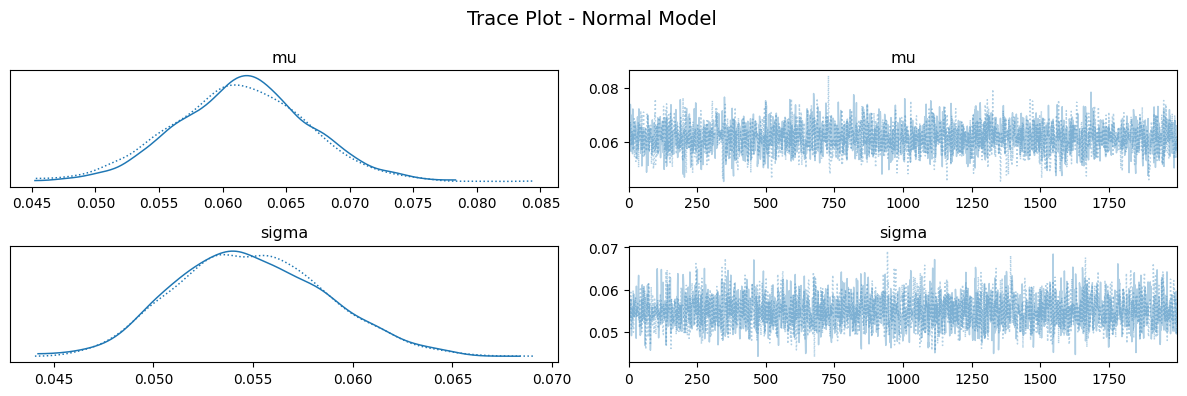

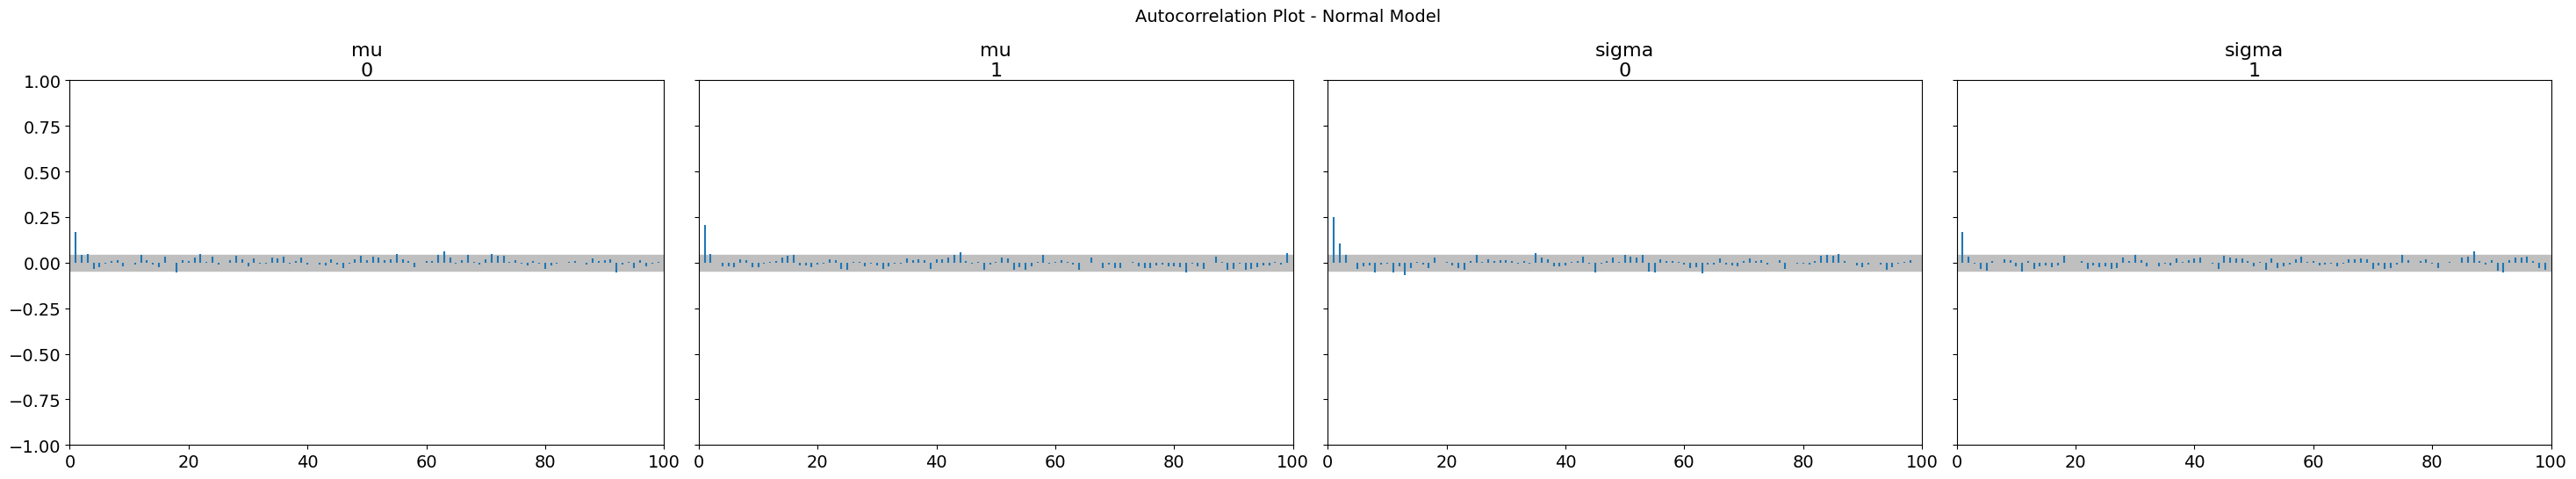

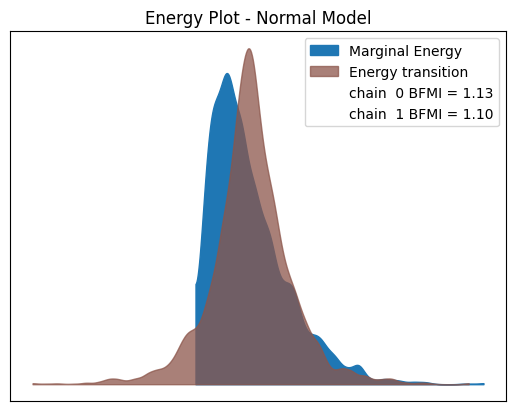

Output()

Output()

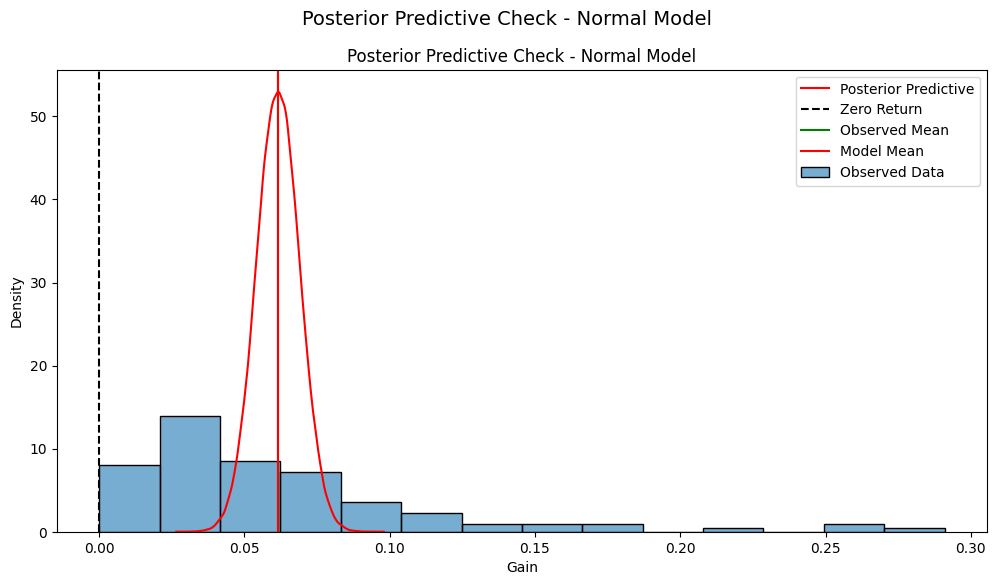


--------------------------------------------------
Fitting and analyzing STUDENT-T model...
--------------------------------------------------


Output()

Output()


Student-t Model Summary:
         mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd   ess_bulk  \
mu     0.0486  0.0042  0.0412   0.0568     0.0001   0.0001  2243.5987   
sigma  0.0324  0.0042  0.0250   0.0405     0.0001   0.0001  2124.8122   
nu     3.1578  1.1065  1.5457   5.0756     0.0266   0.0422  2013.5551   

        ess_tail   r_hat  
mu     2238.4667  1.0007  
sigma  2334.7792  1.0008  
nu     1901.4531  1.0001  
Probability of positive mean return: 100.00%
95% Value-at-Risk: 0.0419
95% Expected Shortfall: 0.0403

Running diagnostics for Student-t model...


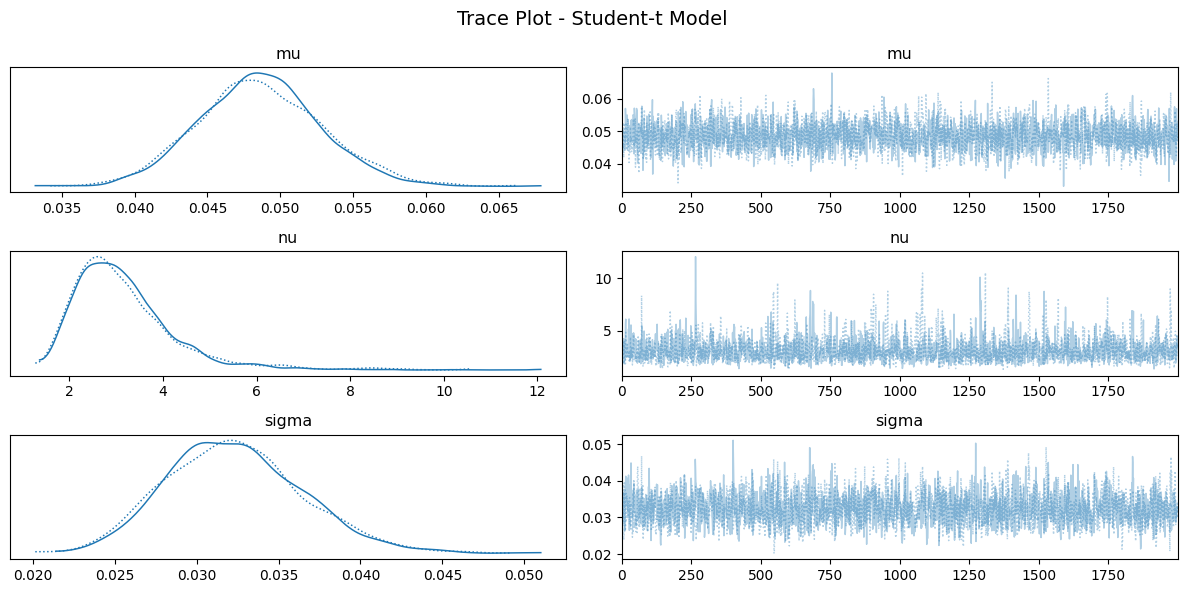

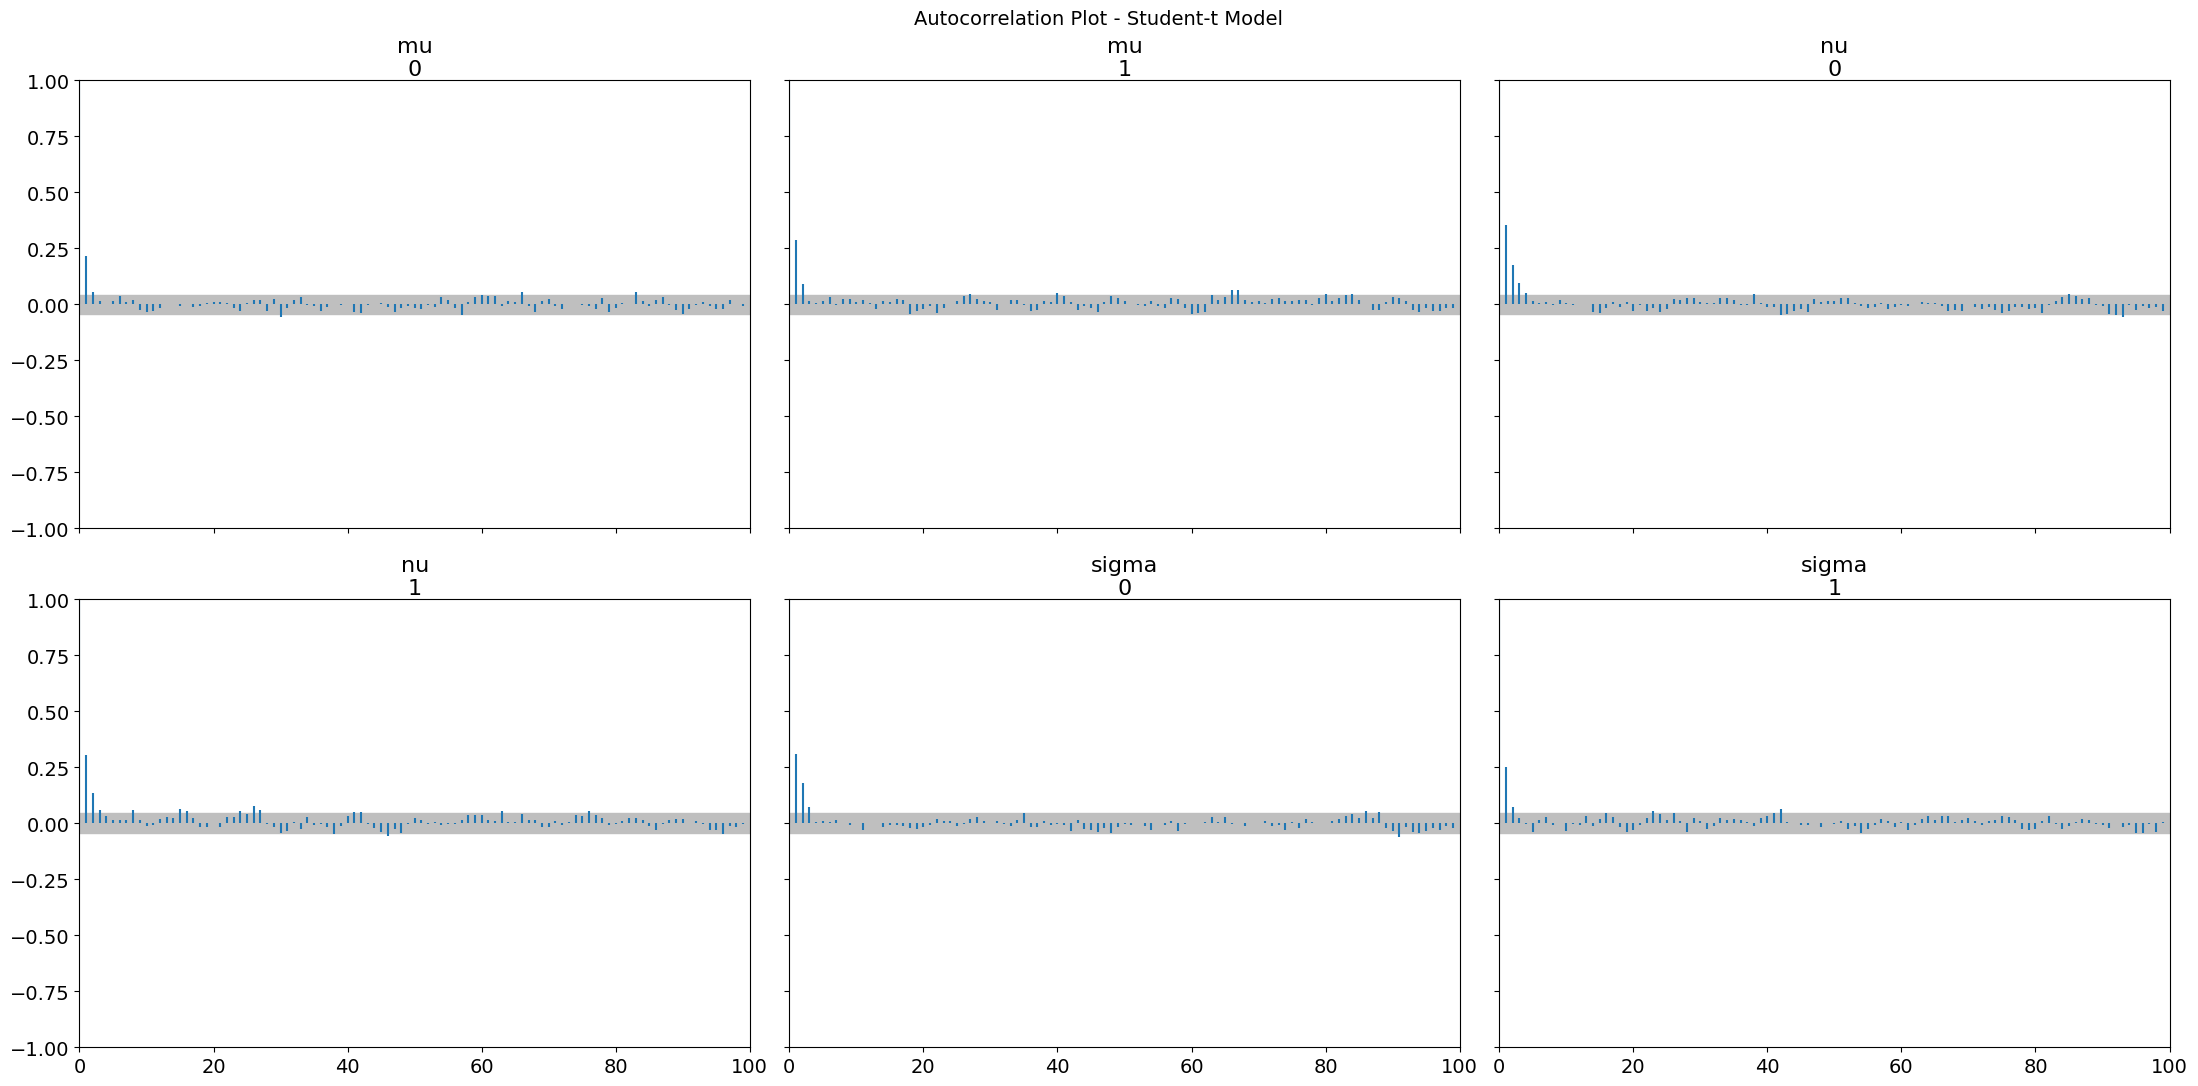

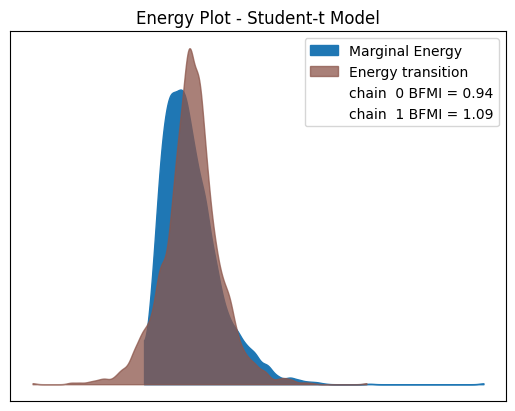

Output()

Output()

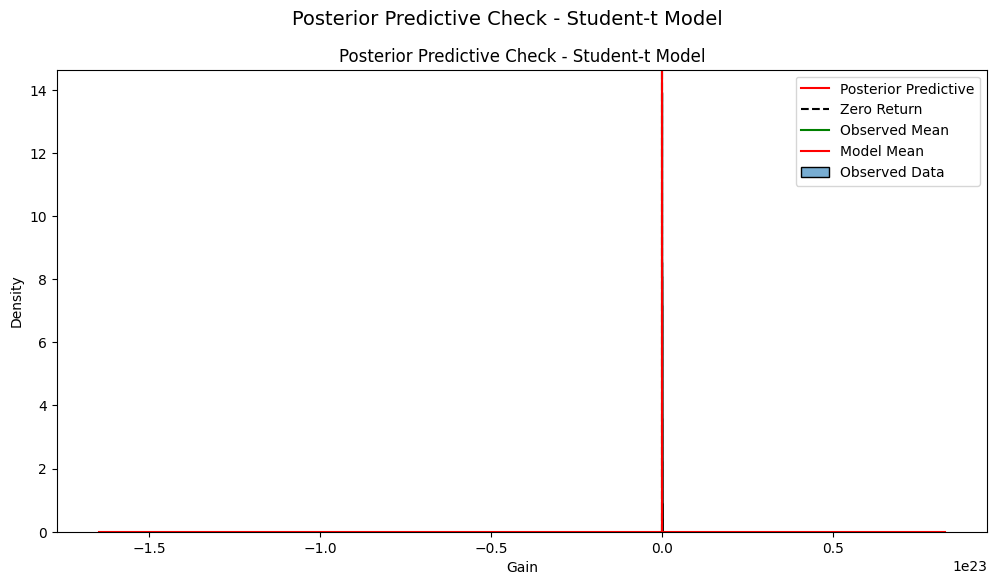

<Figure size 1000x600 with 0 Axes>

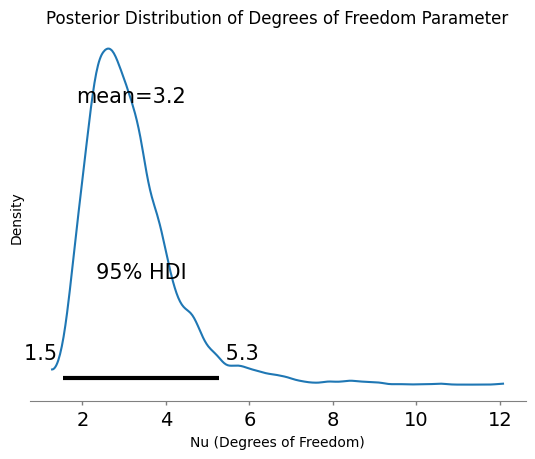


--------------------------------------------------
Fitting and analyzing SKEWED-NORMAL model...
--------------------------------------------------


Output()

Output()


Skewed-normal Model Summary:
         mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd   ess_bulk  \
mu     0.0039  0.0036 -0.0029   0.0106     0.0001   0.0001  2157.9061   
sigma  0.0782  0.0058  0.0674   0.0888     0.0001   0.0001  2361.0176   
alpha  6.7775  1.6199  3.7975   9.7105     0.0327   0.0299  2567.1406   

        ess_tail   r_hat  
mu     2463.4766  1.0003  
sigma  2744.9992  1.0007  
alpha  2362.2007  1.0003  
Probability of positive mean return: 86.65%
95% Value-at-Risk: -0.0020
95% Expected Shortfall: -0.0039

Running diagnostics for Skewed-normal model...


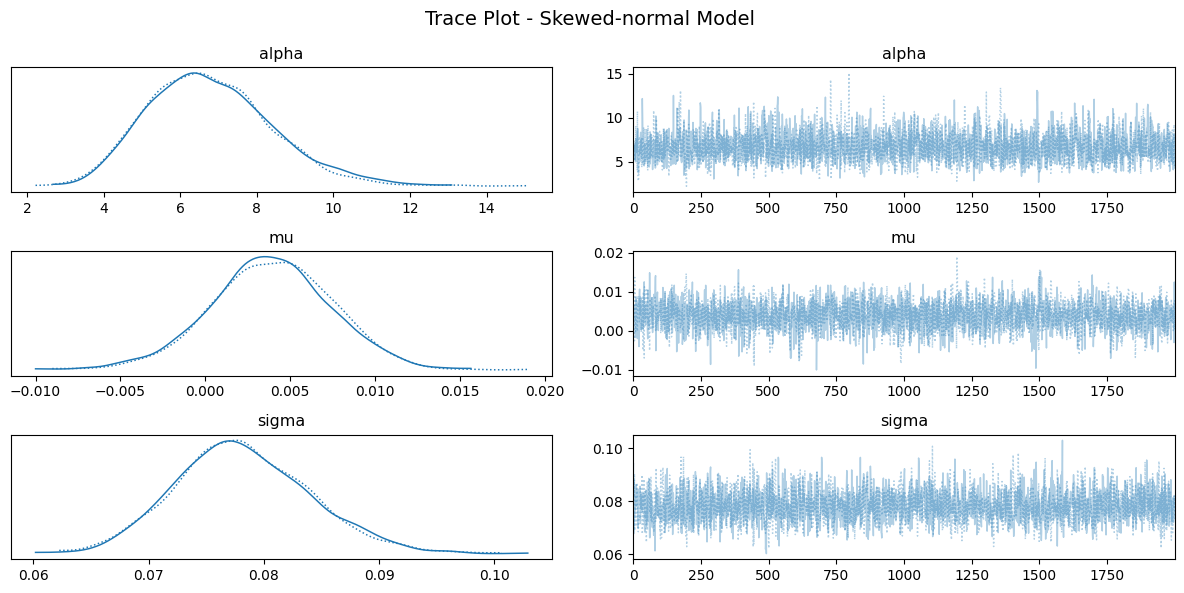

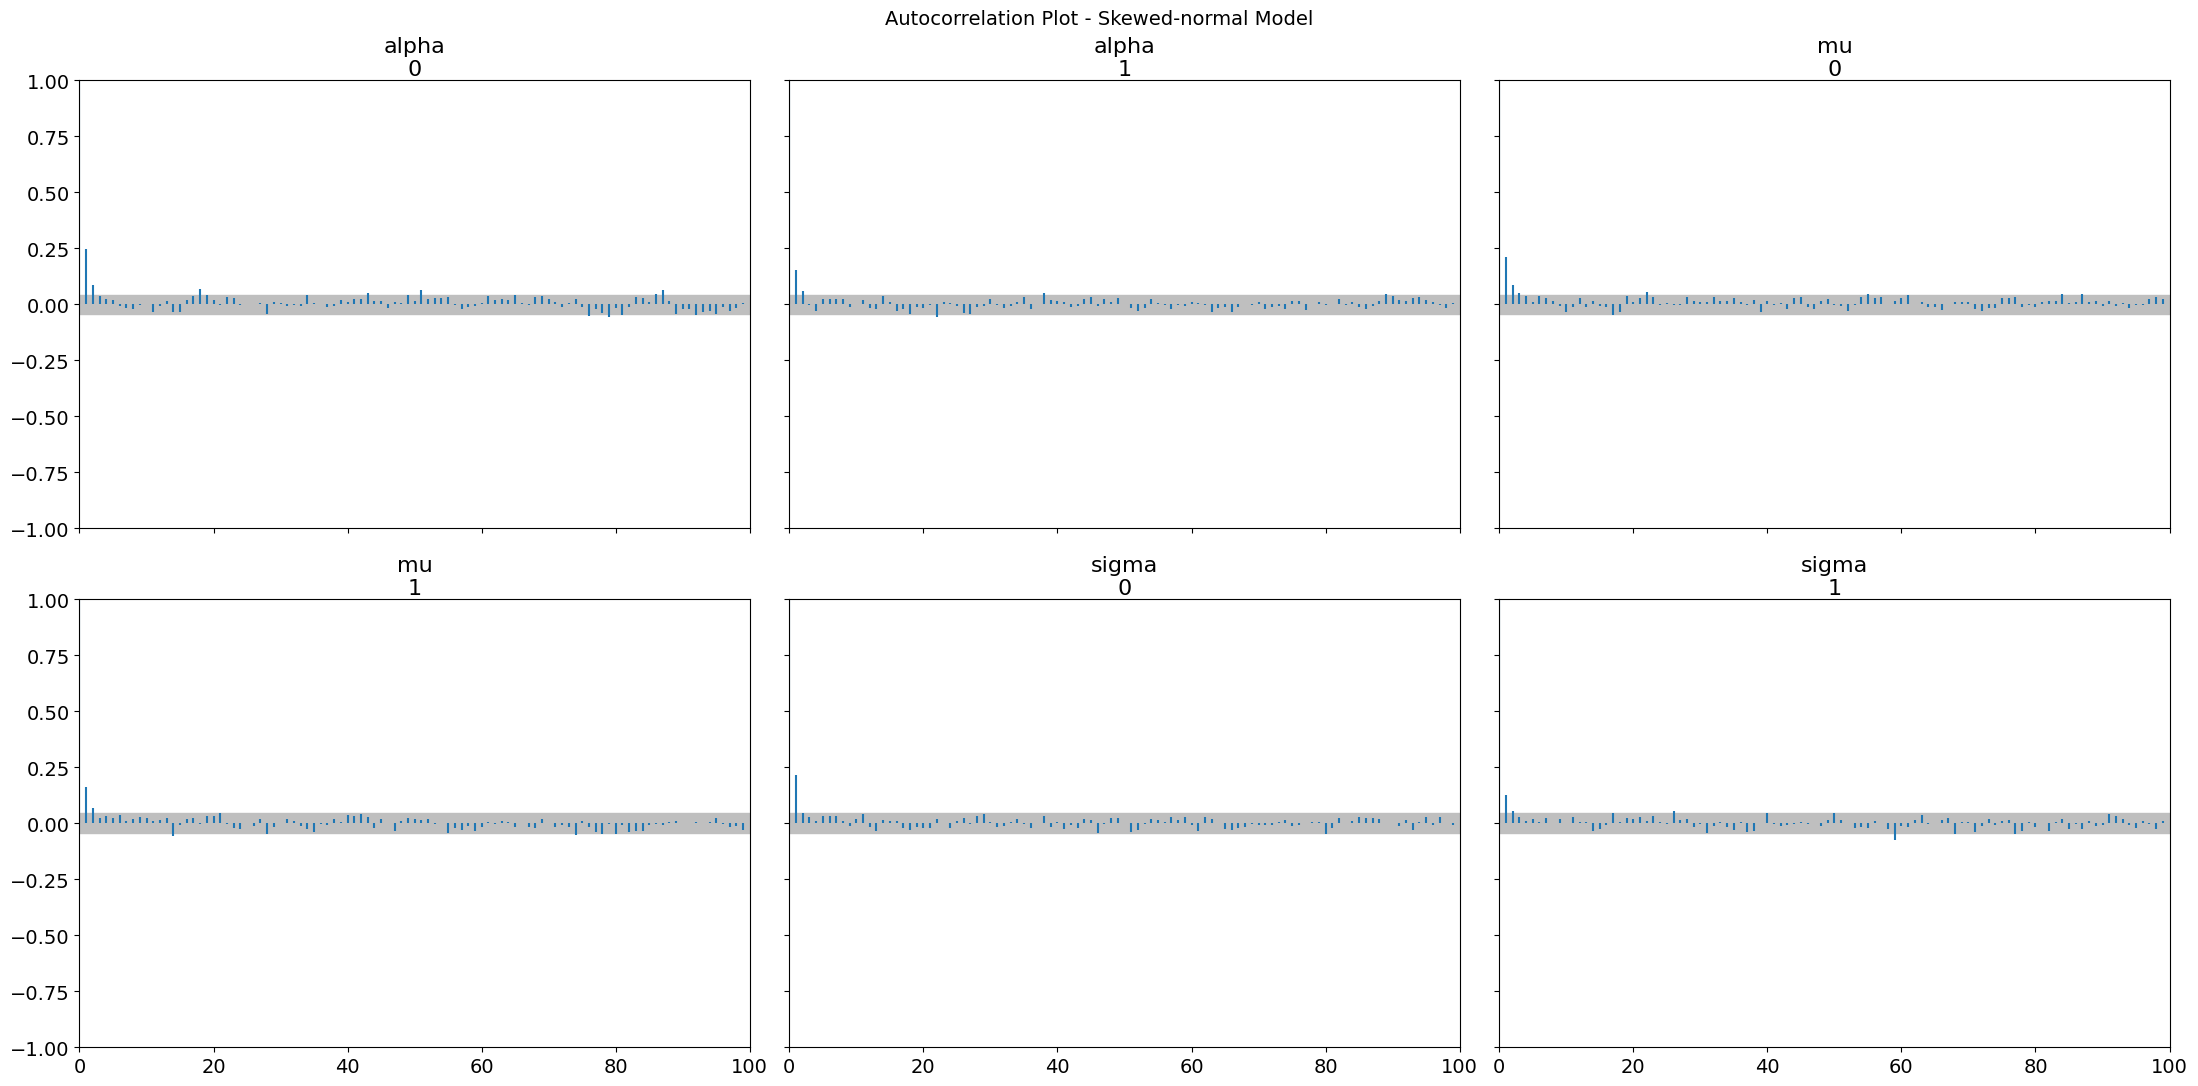

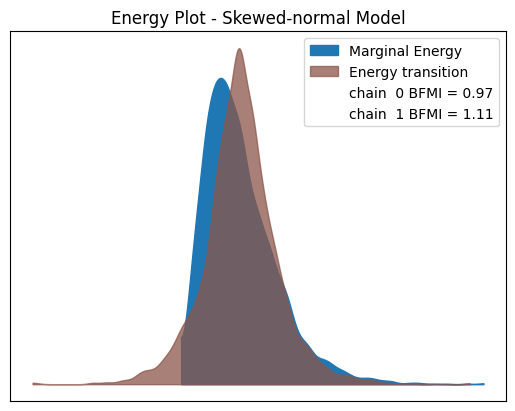

Output()

Output()

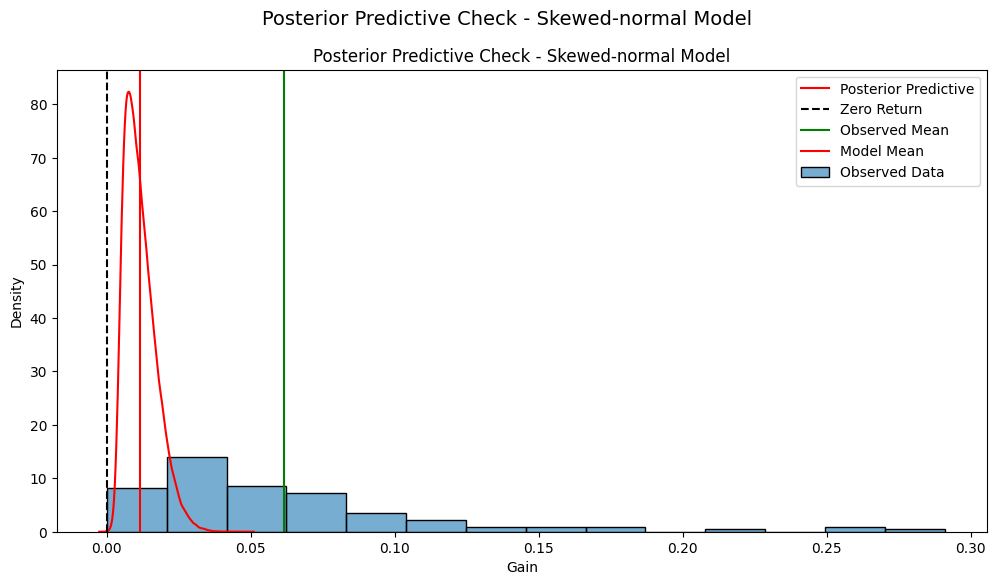

<Figure size 1000x600 with 0 Axes>

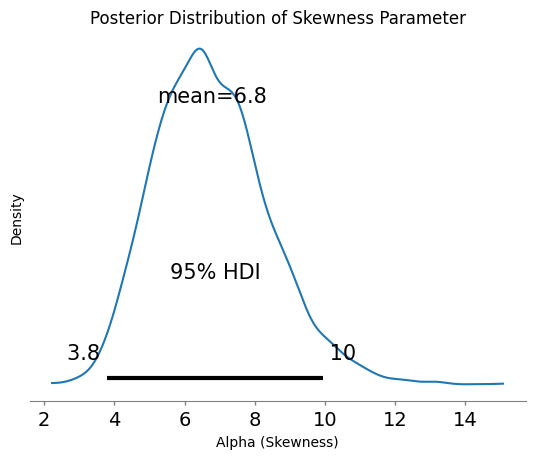


Model Comparison:
           Model           MSE       MAE  P(μ > 0)
0         normal  3.830115e-08  0.000196    1.0000
1      student-t  1.711874e-04  0.013084    1.0000
2  skewed-normal  1.502360e-05  0.003876    0.8665
Best model based on MSE: normal

Calculating baseline statistics for comparison...

20-day baseline statistics (clean baseline, n=5243):
Mean gain: 0.1665
Median gain: 0.0507
Positive gains: 90.1%
Excluded 1030 candles from baseline (hammers + subsequent 10 days)

Comparison - Hammer vs Clean Baseline (20-day):
Hammer mean: 0.0616
Baseline mean: 0.1665
Difference: -0.1049 (-63.0% relative)

--- Parameter Comparison Across Models (20-day) ---
               Mean (μ)  Std Dev (σ)  DoF (ν)  Skewness (α)  P(μ > 0)     MSE  \
normal           0.0615       0.0549      NaN           NaN    1.0000  0.0000   
student-t        0.0486       0.0324   3.1578           NaN    1.0000  0.0002   
skewed-normal    0.0039       0.0782      NaN        6.7775    0.8665  0.0000   

      

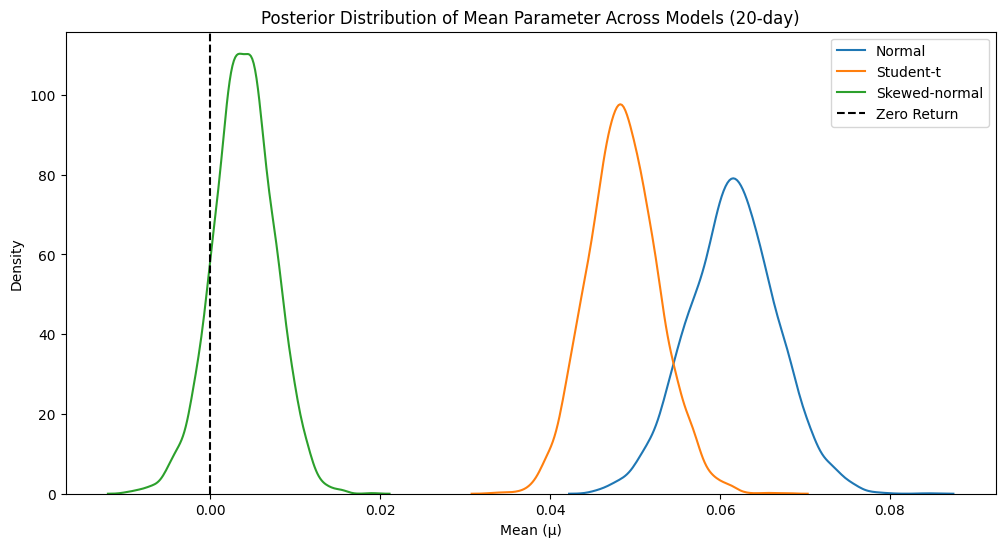


--- Analyzing Prior Sensitivity (Normal Model) ---

Running Normal model with 'weakly_informative' priors...


Output()

Output()

Summary (weakly_informative priors):
         mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd   ess_bulk  \
mu     0.0616  0.0052  0.0513   0.0708     0.0001   0.0001  2780.3884   
sigma  0.0550  0.0038  0.0477   0.0620     0.0001   0.0001  2523.4684   

        ess_tail   r_hat  
mu     2571.5015  1.0006  
sigma  2380.4022  1.0004  
Probability of positive mean return: 100.00%
95% Value-at-Risk: 0.0531
95% Expected Shortfall: 0.0508


<Figure size 800x500 with 0 Axes>

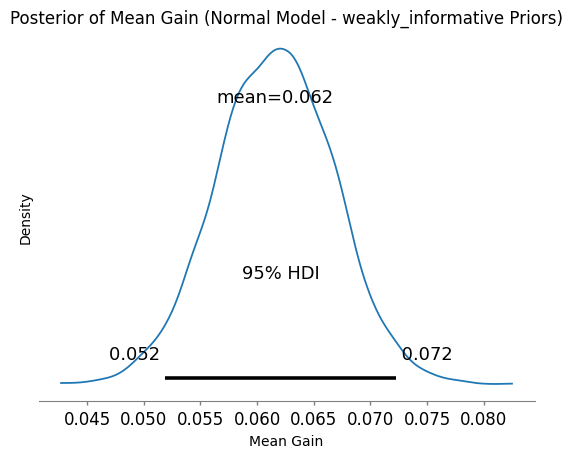


Running Normal model with 'more_informative_mean_positive' priors...


Output()

Output()

Summary (more_informative_mean_positive priors):
         mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd   ess_bulk  \
mu     0.0615  0.0054  0.0511   0.0711     0.0001   0.0001  2808.1060   
sigma  0.0549  0.0038  0.0476   0.0617     0.0001   0.0001  2690.9666   

        ess_tail   r_hat  
mu     2373.9547  1.0006  
sigma  2204.2809  0.9998  
Probability of positive mean return: 100.00%
95% Value-at-Risk: 0.0526
95% Expected Shortfall: 0.0502


<Figure size 800x500 with 0 Axes>

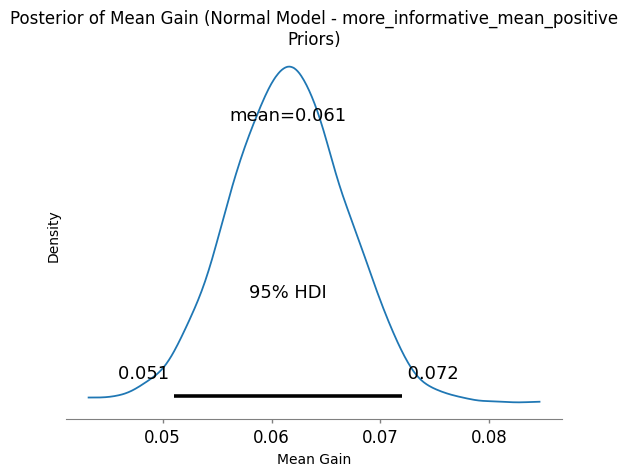


Running Normal model with 'more_informative_mean_negative' priors...


Output()

Output()

Summary (more_informative_mean_negative priors):
         mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd   ess_bulk  \
mu     0.0614  0.0053  0.0516   0.0714     0.0001   0.0001  2214.0866   
sigma  0.0550  0.0038  0.0479   0.0623     0.0001   0.0001  2938.1687   

        ess_tail   r_hat  
mu     1971.9476  0.9999  
sigma  2629.8813  1.0001  
Probability of positive mean return: 100.00%
95% Value-at-Risk: 0.0528
95% Expected Shortfall: 0.0505


<Figure size 800x500 with 0 Axes>

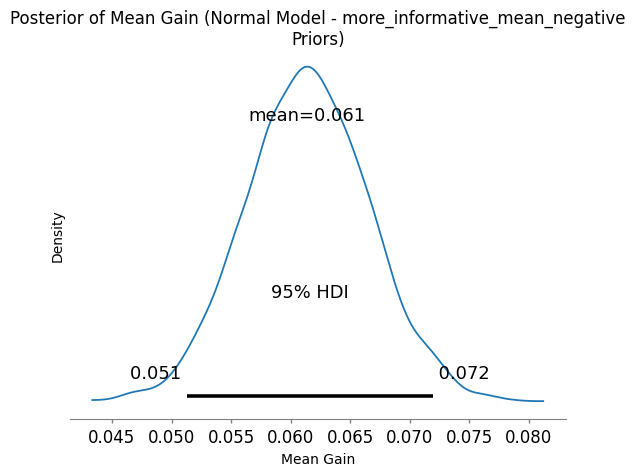


Running Normal model with 'narrow_sigma' priors...


Output()

Output()

Summary (narrow_sigma priors):
         mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd   ess_bulk  \
mu     0.0614  0.0054  0.0518   0.0716     0.0001   0.0001  2965.3356   
sigma  0.0547  0.0037  0.0473   0.0612     0.0001   0.0001  3072.7524   

        ess_tail   r_hat  
mu     2499.8824  0.9997  
sigma  2235.3541  1.0014  
Probability of positive mean return: 100.00%
95% Value-at-Risk: 0.0527
95% Expected Shortfall: 0.0504


<Figure size 800x500 with 0 Axes>

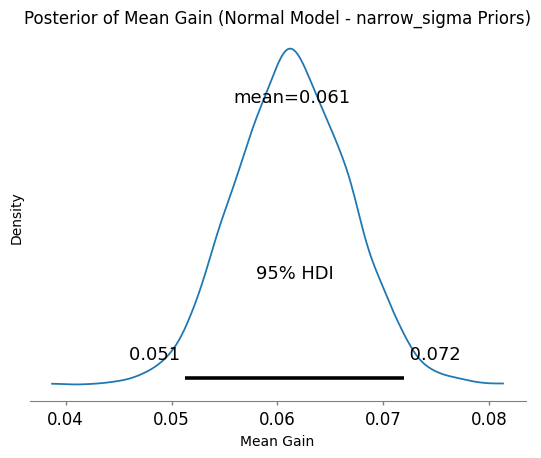


Running Normal model with 'wide_sigma' priors...


Output()

Output()

Summary (wide_sigma priors):
         mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu     0.0616  0.0054  0.0507   0.0711     0.0001   0.0001  2871.601   
sigma  0.0550  0.0037  0.0485   0.0619     0.0001   0.0001  2504.791   

        ess_tail   r_hat  
mu     2321.1410  1.0005  
sigma  2357.3182  1.0003  
Probability of positive mean return: 100.00%
95% Value-at-Risk: 0.0526
95% Expected Shortfall: 0.0506


<Figure size 800x500 with 0 Axes>

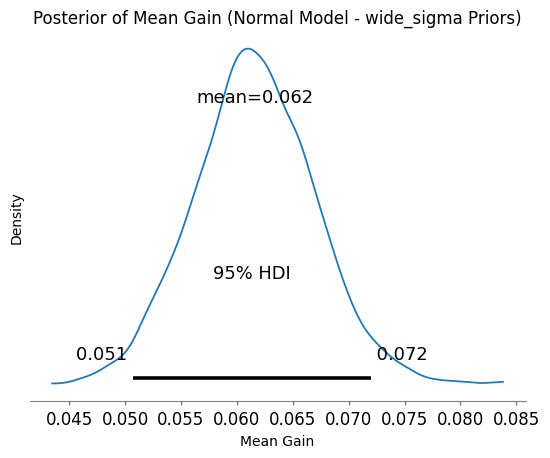


--- Prior Sensitivity Comparison ---
                            Prior  Mean Estimate  Std Dev Estimate  \
0              weakly_informative         0.0616            0.0550   
1  more_informative_mean_positive         0.0615            0.0549   
2  more_informative_mean_negative         0.0614            0.0550   
3                    narrow_sigma         0.0614            0.0547   
4                      wide_sigma         0.0616            0.0550   

   Prob Positive Return   95% VaR    95% ES  
0                   1.0  0.053051  0.050782  
1                   1.0  0.052584  0.050173  
2                   1.0  0.052800  0.050512  
3                   1.0  0.052657  0.050437  
4                   1.0  0.052582  0.050564  

=== ANALYSIS CONCLUSIONS ===

For 20-day horizon:
• Hammer patterns showed 6.16% average gain
• Clean baseline (excluding hammers and 10 days after) was 16.65% average gain
• Edge from hammer pattern: -10.49%
• Best fitting model: Normal
• Hammers underperformed t

In [27]:
if __name__ == "__main__":
    try:
        # Using 20-day period and excluding 10 days after hammer for baseline
        data, results, baseline_stats = run_hammer_analysis("itc_price.csv", forward_periods=[20], exclude_period=10)

        # Comparing parameters across models
        if 20 in results and 'bayesian_traces' in results[20]:
            param_comparison = compare_model_parameters(results, period=20)

        # Performing prior sensitivity analysis on the 20-day gains
        if 20 in results and len(results[20]['gains']) > 0:
            prior_results = analyze_prior_sensitivity(results[20]['gains'])

            # Comparing prior impacts on key metrics
            if prior_results:
                print("\n--- Prior Sensitivity Comparison ---")
                metrics_df = pd.DataFrame({
                    'Prior': list(prior_results.keys()),
                    'Mean Estimate': [result['summary'].loc['mu', 'mean'] for result in prior_results.values()],
                    'Std Dev Estimate': [result['summary'].loc['sigma', 'mean'] for result in prior_results.values()],
                    'Prob Positive Return': [result['prob_pos_returns'] for result in prior_results.values()],
                    '95% VaR': [result['var_95'] for result in prior_results.values()],
                    '95% ES': [result['es_95'] for result in prior_results.values()]
                })
                print(metrics_df)

        # Final conclusions
        print("\n=== ANALYSIS CONCLUSIONS ===")

        # 20-day period analysis
        if 20 in results and 20 in baseline_stats and results[20]['gains'].size > 0:
            hammer_mean = results[20]['gains'].mean()
            baseline_mean = baseline_stats[20]['mean']
            difference = hammer_mean - baseline_mean

            # best model
            best_model = results[20].get('best_model', 'normal')

            print(f"\nFor 20-day horizon:")
            print(f"• Hammer patterns showed {hammer_mean:.2%} average gain")
            print(f"• Clean baseline (excluding hammers and 10 days after) was {baseline_mean:.2%} average gain")
            print(f"• Edge from hammer pattern: {difference:.2%}")
            print(f"• Best fitting model: {best_model.capitalize()}")

            if hammer_mean > baseline_mean:
                print(f"• Hammers outperformed the baseline by {(hammer_mean/baseline_mean - 1)*100:.1f}%")
            else:
                print(f"• Hammers underperformed the baseline by {(1 - hammer_mean/baseline_mean)*100:.1f}%")

            pos_rate_hammer = (results[20]['gains'] > 0).mean()
            pos_rate_baseline = baseline_stats[20]['positive_rate']
            print(f"• Win rate: {pos_rate_hammer:.1%} for hammers vs {pos_rate_baseline:.1%} baseline")

            # Bayesian conclusion (using best model if available)
            if 'bayesian_traces' in results[20] and best_model in results[20]['bayesian_traces']:
                prob_pos = (results[20]['bayesian_traces'][best_model].posterior["mu"] > 0).mean().item()
                print(f"• Bayesian probability of positive expected return ({best_model.capitalize()} Model): {prob_pos:.1%}")

                # Trading recommendation
                print("\nTrading recommendation:")
                if hammer_mean > baseline_mean*1.2 and prob_pos > 0.95:
                    print("STRONG BUY signal after valid hammer patterns")
                elif hammer_mean > baseline_mean and prob_pos > 0.8:
                    print("BUY signal after valid hammer patterns")
                elif hammer_mean > baseline_mean:
                    print("WEAK BUY signal after valid hammer patterns")
                else:
                    print("NO SIGNIFICANT EDGE found for hammer patterns in this dataset")
            else:
                print("Bayesian analysis results not available for final recommendation.")

    except Exception as e:
        print(f"Error in analysis: {str(e)}")
        import traceback
        traceback.print_exc()

In [25]:
def calculate_clean_baseline(data, period=20, exclude_window=10):
    """
    Calculate a clean baseline by excluding hammer patterns and their subsequent candles.

    Parameters:
    -----------
    data : pandas DataFrame
        The full dataset including hammer patterns
    period : int
        The forward period for gain calculation (e.g. 20 days)
    exclude_window : int
        Number of candles to exclude after each hammer to avoid overlap effects

    Returns:
    --------
    dict : Dictionary of baseline statistics
    """
    # Get the gain column name
    gain_col = f'Max_Gain_{period}d'

    # Create a mask for rows to exclude (hammer candles + window after them)
    exclude_mask = pd.Series(False, index=data.index)

    # Find indices of all hammer candles
    hammer_indices = data[data['Valid_Hammer'] == True].index

    # For each hammer, mark it and the next exclude_window candles to be excluded
    for idx in hammer_indices:
        if idx in data.index:  # Safety check
            pos = data.index.get_loc(idx)
            # Mark the hammer itself
            exclude_mask.iloc[pos] = True

            # Mark the subsequent window
            for i in range(1, exclude_window + 1):
                if pos + i < len(exclude_mask):
                    exclude_mask.iloc[pos + i] = True

    # Create the "clean" dataset excluding hammers and their effects
    clean_data = data[~exclude_mask]

    # Calculate baseline statistics on the clean data
    clean_gains = clean_data[gain_col].dropna().values

    if len(clean_gains) > 0:
        baseline_stats = {
            'mean': clean_gains.mean(),
            'median': np.median(clean_gains),
            'positive_rate': (clean_gains > 0).mean(),
            'count': len(clean_gains),
            'std': clean_gains.std()
        }

        print(f"\nClean baseline statistics (excluding hammers and next {exclude_window} candles, n={len(clean_gains)}):")
        print(f"Mean gain: {clean_gains.mean():.4f}")
        print(f"Median gain: {np.median(clean_gains):.4f}")
        print(f"Positive gains: {(clean_gains > 0).mean()*100:.1f}%")

        return baseline_stats
    else:
        print(f"Warning: No clean data available after excluding hammers and {exclude_window} candles after each.")
        return None

# Modified run_hammer_analysis function with both baseline types
def run_hammer_analysis(file_path, forward_periods=[20], exclude_window=10):
    """Complete analysis pipeline for hammer patterns with expanded diagnostics and clean baseline"""
    # Load and preprocess data
    print("Loading and preprocessing data...")
    data = load_and_preprocess_data(file_path)

    # Identify patterns
    print("Identifying hammer patterns...")
    data = identify_patterns(data)

    # Calculate future gains
    print("Calculating future gains...")
    data = calculate_future_gains(data, forward_periods)

    # Get gain column names
    gain_cols = [f'Max_Gain_{period}d' for period in forward_periods]
    loss_cols = [f'Max_Loss_{period}d' for period in forward_periods]
    rr_cols = [f'Risk_Reward_{period}d' for period in forward_periods]

    # Generate descriptive statistics
    print("Generating descriptive statistics...")
    stats, pattern_data = descriptive_stats(data, 'Valid_Hammer', gain_cols + loss_cols + rr_cols)

    # Count the total hammers found
    total_hammers = len(pattern_data)
    print(f"\nTotal hammer patterns found: {total_hammers}")

    # Store results for each time period
    results = {}

    # [Rest of the analysis code remains the same...]

    # Add baseline comparison
    print("\nCalculating baseline statistics for comparison...")
    baseline_stats = {}
    clean_baseline_stats = {}

    for period in forward_periods:
        gain_col = f'Max_Gain_{period}d'

        # 1. REGULAR BASELINE (all candles)
        all_valid_gains = data[gain_col].dropna().values

        if len(all_valid_gains) > 0:
            baseline_stats[period] = {
                'mean': all_valid_gains.mean(),
                'median': np.median(all_valid_gains),
                'positive_rate': (all_valid_gains > 0).mean(),
                'count': len(all_valid_gains),
                'std': all_valid_gains.std()
            }

            print(f"\n{period}-day baseline statistics (all candles, n={len(all_valid_gains)}):")
            print(f"Mean gain: {all_valid_gains.mean():.4f}")
            print(f"Median gain: {np.median(all_valid_gains):.4f}")
            print(f"Positive gains: {(all_valid_gains > 0).mean()*100:.1f}%")

        # 2. CLEAN BASELINE (excluding hammers and window after them)
        clean_baseline_stats[period] = calculate_clean_baseline(data, period, exclude_window)

        # Compare hammer to both baselines
        if period in results and results[period]['gains'].size > 0:
            hammer_mean = results[period]['gains'].mean()
            hammer_std = results[period]['gains'].std() if len(results[period]['gains']) > 1 else 0

            # Standard baseline comparison
            baseline_mean = all_valid_gains.mean()
            difference = hammer_mean - baseline_mean

            print(f"\nComparison - Hammer vs All Candles ({period}-day):")
            print(f"Hammer mean: {hammer_mean:.4f}")
            print(f"Baseline mean: {baseline_mean:.4f}")
            print(f"Difference: {difference:.4f} ({difference/abs(baseline_mean)*100:.1f}% relative)")

            # Clean baseline comparison (if available)
            if clean_baseline_stats[period]:
                clean_mean = clean_baseline_stats[period]['mean']
                clean_difference = hammer_mean - clean_mean

                print(f"\nComparison - Hammer vs Clean Baseline ({period}-day):")
                print(f"Hammer mean: {hammer_mean:.4f}")
                print(f"Clean baseline mean: {clean_mean:.4f}")
                print(f"Difference: {clean_difference:.4f} ({clean_difference/abs(clean_mean)*100:.1f}% relative)")

                # Statistical significance test (t-test)
                try:
                    from scipy import stats
                    clean_gains = data[~data['Valid_Hammer'] & ~data.rolling(exclude_window).apply(lambda x: any(x['Valid_Hammer']), raw=True).fillna(False)][gain_col].dropna().values

                    t_stat, p_value = stats.ttest_ind(results[period]['gains'], clean_gains, equal_var=False)
                    print(f"Statistical significance: t={t_stat:.2f}, p-value={p_value:.4f}")
                    print(f"{'Statistically significant' if p_value < 0.05 else 'Not statistically significant'} at 95% confidence level")
                except Exception as e:
                    print(f"Could not calculate statistical significance: {str(e)}")

    return data, results, baseline_stats, clean_baseline_stats

# Modified conclusion section to use clean baseline
def print_conclusions(results, baseline_stats, clean_baseline_stats, period=20):
    """Print conclusions using both regular and clean baselines"""
    print("\n=== ANALYSIS CONCLUSIONS ===")

    # Period analysis
    if period in results and period in baseline_stats and results[period]['gains'].size > 0:
        hammer_mean = results[period]['gains'].mean()
        baseline_mean = baseline_stats[period]['mean']
        difference = hammer_mean - baseline_mean

        # Get the best model if available
        best_model = results[period].get('best_model', 'normal')

        print(f"\nFor {period}-day horizon:")
        print(f"• Hammer patterns showed {hammer_mean:.2%} average gain")
        print(f"• Overall market baseline was {baseline_mean:.2%} average gain")
        print(f"• Edge from hammer pattern (vs all candles): {difference:.2%}")

        # Add clean baseline comparison if available
        if period in clean_baseline_stats and clean_baseline_stats[period]:
            clean_mean = clean_baseline_stats[period]['mean']
            clean_diff = hammer_mean - clean_mean
            print(f"• Clean baseline (excluding hammers & effects) was {clean_mean:.2%}")
            print(f"• True edge from hammer pattern: {clean_diff:.2%}")

            # Edge evaluation using clean baseline
            if hammer_mean > clean_mean:
                print(f"• Hammers outperformed clean baseline by {(hammer_mean/clean_mean - 1)*100:.1f}%")
            else:
                print(f"• Hammers underperformed clean baseline by {(1 - hammer_mean/clean_mean)*100:.1f}%")

        print(f"• Best fitting model: {best_model.capitalize()}")

        # Win rate comparison
        pos_rate_hammer = (results[period]['gains'] > 0).mean()
        pos_rate_baseline = baseline_stats[period]['positive_rate']
        print(f"• Win rate: {pos_rate_hammer:.1%} for hammers vs {pos_rate_baseline:.1%} baseline")

        if period in clean_baseline_stats and clean_baseline_stats[period]:
            pos_rate_clean = clean_baseline_stats[period]['positive_rate']
            print(f"• Win rate vs clean baseline: {pos_rate_hammer:.1%} for hammers vs {pos_rate_clean:.1%} clean baseline")

        # Bayesian conclusion (using best model if available)
        if 'bayesian_traces' in results[period] and best_model in results[period]['bayesian_traces']:
            prob_pos = (results[period]['bayesian_traces'][best_model].posterior["mu"] > 0).mean().item()
            print(f"• Bayesian probability of positive expected return ({best_model.capitalize()} Model): {prob_pos:.1%}")

            # Trading recommendation based on clean baseline if available
            reference_mean = clean_mean if period in clean_baseline_stats and clean_baseline_stats[period] else baseline_mean

            print("\nTrading recommendation:")
            if hammer_mean > reference_mean*1.2 and prob_pos > 0.95:
                print("STRONG BUY signal after valid hammer patterns")
            elif hammer_mean > reference_mean and prob_pos > 0.8:
                print("BUY signal after valid hammer patterns")
            elif hammer_mean > reference_mean:
                print("WEAK BUY signal after valid hammer patterns")
            else:
                print("NO SIGNIFICANT EDGE found for hammer patterns in this dataset")
        else:
            print("Bayesian analysis results not available for final recommendation.")